# Initial EDA
What's in here that looks useful?

In [1]:
import pandas as pd
import seaborn as sns

sns.set_theme(style='darkgrid')

## First load the data and get basic info

In [2]:
# Load from "db"
db = pd.read_csv('data/startingover.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48565 entries, 0 to 48564
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   author               48544 non-null  object 
 1   created_utc          48565 non-null  float64
 2   distinguished        47 non-null     object 
 3   edited               48565 non-null  object 
 4   id                   48565 non-null  object 
 5   is_original_content  48565 non-null  bool   
 6   is_self              48565 non-null  bool   
 7   link_flair_text      25836 non-null  object 
 8   locked               48565 non-null  bool   
 9   name                 48565 non-null  object 
 10  num_comments         48565 non-null  int64  
 11  over_18              48565 non-null  bool   
 12  permalink            48565 non-null  object 
 13  score                48565 non-null  int64  
 14  selftext             2243 non-null   object 
 15  spoiler              48565 non-null 

'num_comments' is going to be the target, let's get a closer look at the distribution

count    48565.000000
mean        84.723463
std        346.739562
min          0.000000
25%         10.000000
50%         26.000000
75%         69.000000
max      27985.000000
Name: num_comments, dtype: float64


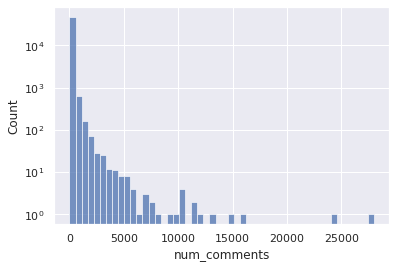

In [3]:
print(db.num_comments.describe())
sns.histplot(db.num_comments,log_scale=(False,True),bins=50);

This appears to be heavily impacted by outliers, I'll pick a cutoff at 6000 comments and see where that gets us

In [4]:
len(db[db.num_comments>6000])

21

There are some extreme outliers here, they're skewing the data and there are so few of them that we won't miss them at all. So we'll drop and re-plot

count    48544.000000
mean        79.740957
std        223.601340
min          0.000000
25%         10.000000
50%         26.000000
75%         68.250000
max       5876.000000
Name: num_comments, dtype: float64


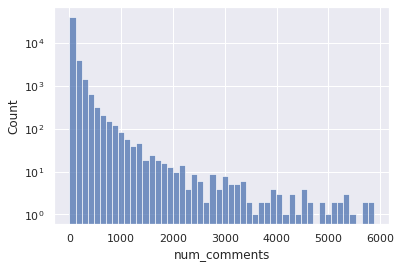

In [5]:
db = db.drop(db[db.num_comments>6000].index)
print(db.num_comments.describe())
sns.histplot(db.num_comments,log_scale=(False,True),bins=50);

Much clearer picture, also I put the plots on a log scale so we can actually see the distribution, otherwise it'd just be a massive bar at 0 and it would push everything else so far down that you can't see anything. I could probably go further but I don't want to misrepresent the data

## Comparing Features
There are a few features that jumped out at me as interesting:

In [6]:
print(f'\
Out of {len(db)} total posts...\n\
--------------------------------\n\
{db.is_self.value_counts()[True]} posts are self posts\n\
{db.over_18.value_counts()[True]} posts are NSFW (18+)\n\
{db.spoiler.value_counts()[True]} posts are marked as spoilers\n\
{db.is_original_content.value_counts()[True]} posts are of original content\n\
{db.locked.value_counts()[True]} posts are locked\n\
{db.stickied.value_counts()[True]} posts are stickied\n\
')

Out of 48544 total posts...
--------------------------------
2495 posts are self posts
1001 posts are NSFW (18+)
866 posts are marked as spoilers
830 posts are of original content
212 posts are locked
145 posts are stickied



While the number of these posts compared to the total posts isn't significant I feel that they can only add (not much) to the accuracy of the model. They only add one column each so it's cheap as well. If I had more time I would probably create a column for has_flair as well.

## Numerics vs Target
Some numeric columns I would like to include are score, post age, upvote ratio, and number of comments (which will become the target). Let's get an idea for what's going on.

count     48544.000000
mean       2130.988176
std        6702.179836
min          45.000000
25%         263.000000
50%         568.000000
75%        1465.000000
max      193501.000000
Name: score, dtype: float64


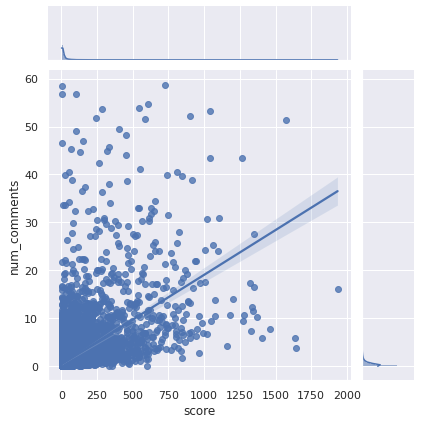

In [7]:
print(db.score.describe())
sns.jointplot(x=db.score/100,y=db.num_comments/100,kind='reg');

Both axes divided by 100 to make it easier to read

Score is a strong predictor of number of comments, the highest scoring posts are almost guaranteed to have an above-median number of comments.

count     48544.000000
mean      59368.201209
std       23001.003540
min       14846.543459
25%       41004.177545
50%       57975.297003
75%       76686.219161
max      101274.168406
Name: post_age, dtype: float64


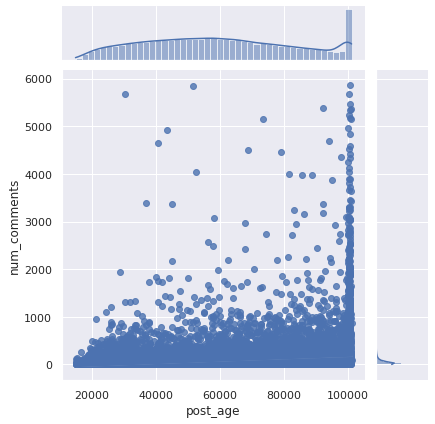

In [8]:
print(db.post_age.describe())
sns.jointplot(x=db.post_age,y=db.num_comments, kind='reg');

It could be clearer, but there is some correlation with age and post count. You can also see how sparse super hot posts actually are.

In [9]:
db[db.num_comments>4000].sort_values('num_comments',ascending=False)[['title','subreddit','num_comments','score']].head(10)

,title,subreddit,num_comments,score
38037,to push past armed courtroom guards,therewasanattempt,5876,72261
36183,Avs VS Oilers Western Conference Finals Game 4...,ColoradoAvalanche,5851,300
33841,"Live WWE RAW Discussion Thread! - June 6th, 2022!",SquaredCircle,5682,128
36694,What would you never tell your current partner?,AskMen,5679,10159
1181,Nearly half of families with kids can no longe...,news,5464,60516
28900,Ohio House Republicans vote to put Canada on a...,nottheonion,5389,53999
39946,"Elon Musk asserts his ""right to terminate"" Twi...",technology,5369,28363
28235,Prince Louis of Cambridge,funny,5334,104033
32875,"""Everybody is trying to blame us""",PublicFreakout,5230,89886
7931,My GF’s friend stayed with us last weekend (fo...,iamverybadass,5173,24474


I expected to see mostly news here, and while news and current events is here (30% in my case at time of writing) the rest of it is drastically different. Anything can go viral it seems

In [10]:
db[db.num_comments>4000].sort_values('score',ascending=False)[['title','subreddit','num_comments','score']].head(10)

,title,subreddit,num_comments,score
46529,More of this please.,MadeMeSmile,5146,157009
47421,Helicopter footage of a loose cow being wrangl...,interestingasfuck,4347,126608
28235,Prince Louis of Cambridge,funny,5334,104033
16638,This $10 salad I paid for at a restaurant,mildlyinfuriating,4336,103858
32875,"""Everybody is trying to blame us""",PublicFreakout,5230,89886
22957,Even the military knows assault rifles belong ...,WhitePeopleTwitter,4047,80801
38037,to push past armed courtroom guards,therewasanattempt,5876,72261
1181,Nearly half of families with kids can no longe...,news,5464,60516
19201,"It Costs $110,000 to Fully Gear-Up in Diablo I...",technology,5150,58244
11976,Electric Vehicles are measurably reducing glob...,technology,4120,55080


Sorting by score is a similar story. This is where machine learning really blows my mind, there's no apparent correlation here but somehow it manages to find it

count    48544.000000
mean         0.963388
std          0.041302
min          0.510000
25%          0.950000
50%          0.980000
75%          0.990000
max          1.000000
Name: upvote_ratio, dtype: float64


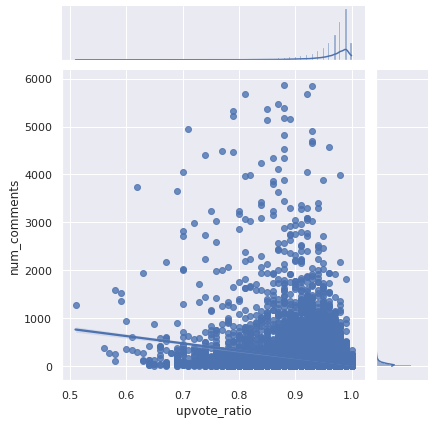

In [11]:
print(db.upvote_ratio.describe())
sns.jointplot(x=db.upvote_ratio,y=db.num_comments, kind='reg');

Upvote ratio goes down as the number of comments increases, at first I thought this seemed backwards but I guess the majority of reddit comments are of such low quality that it drives the metric down into the dirt

## Create Working Dataframes

Let's put it in a dataframe so we can work with it. And also drop any NAs that appear (I don't see any, but I don't want any if they appear in the future)

In [12]:
db[['title','subreddit','over_18','is_original_content','is_self','spoiler',\
         'locked','stickied','num_comments']].dropna().to_csv('data/workingdf.csv',index=False)

db[['score','post_age','upvote_ratio']].to_csv('data/numerics.csv',index=False)

Next, we [clean](clean.ipynb)